In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
games = 'train.csv'
gamesdf = pd.read_csv(games, header=0)

gamesdf['group_num'] = gamesdf.groupby('game_id').cumcount() + 1
pivoted_df = gamesdf.pivot(index='game_id', columns='group_num', values=['nickname', 'score', 'rating'])
pivoted_df.columns = [f'{col[0]}{col[1]}' for col in pivoted_df.columns]
pivoted_df['rating1'] = pd.to_numeric(pivoted_df['rating1'])
pivoted_df['rating2'] = pd.to_numeric(pivoted_df['rating2'])
pivoted_df['score1'] = pd.to_numeric(pivoted_df['score1'])
pivoted_df['score2'] = pd.to_numeric(pivoted_df['score2'])


In [ ]:
data = pivoted_df

y = data.iloc[:, -1]
X = data.drop(data.columns[[-1, 0, 1]], axis=1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_indices = X.index.values
y_indices = y.index.values

print(X)
print(y)

         score1  score2  rating1
game_id                         
1           335     429     1637
3           440     318     1811
4           119     478     1473
5           325     427     1500
6           378     427     2029
...         ...     ...      ...
72767       340     414     1395
72770       590      97     2237
72771       390     393     1500
72772       442     388     1674
72773       383     346     2075

[50410 rows x 3 columns]
game_id
1        1500
3        2071
4        1936
5        1844
6        2143
         ... 
72767    1952
72770    1332
72771    1614
72772    1364
72773    2302
Name: rating2, Length: 50410, dtype: int64


In [ ]:
# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'base_estimator__max_depth': [7],  # Max depth of the base decision tree regressor
    'n_estimators': [1000],  # Number of estimators (base learners)
    'learning_rate': [0.001]  # Learning rate
}

# Create the base Decision Tree Regressor
base_estimator = DecisionTreeRegressor()

# Create the AdaBoost Regressor
adaboost_regressor = AdaBoostRegressor(base_estimator=base_estimator, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(adaboost_regressor, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_adaboost_regressor = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_adaboost_regressor.predict(X_test)

# Evaluate the model using mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Best Hyperparameters:", grid_search.best_params_)
print("Mean Squared Error (MSE):", mse)

Best Hyperparameters: {'base_estimator__max_depth': 7, 'learning_rate': 0.001, 'n_estimators': 1000}
Mean Squared Error (MSE): 26143.00687890912


C:\Users\Nick_\AppData\Local\Temp\ipykernel_14128\121083039.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, color='red', label='Perfect Fit')


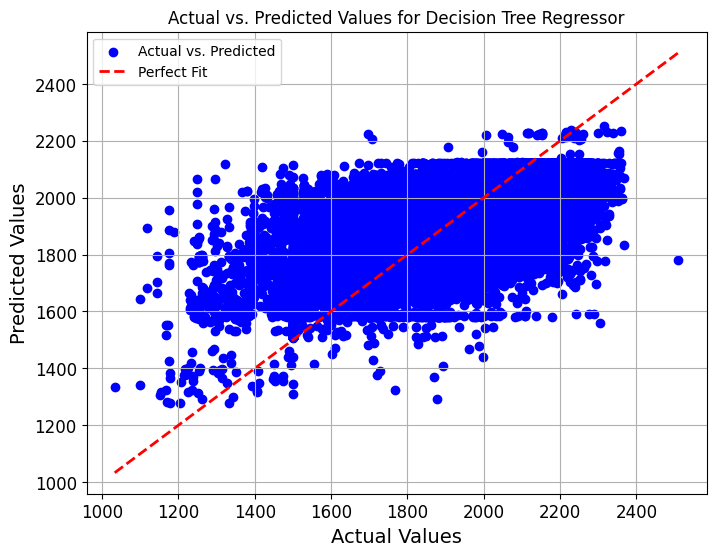

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the actual target values in y_test and predicted values in y_pred (from the best model)

# Create a scatter plot to show the best-fit predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, color='red', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Decision Tree Regressor')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()